Stock-Price-Prediction

In [1]:
import yfinance as yf
import pandas as pd
import os

In [4]:
if os.path.exists("/Minor Project Data set (Stock Price Prediction).xlsx"):
    data = pd.read_csv("/Minor Project Data set (Stock Price Prediction).xlsx", index_col=0)
else:
    data = yf.Ticker("^GSPC")
    data = data.history(period="max")
    data.to_xlsx("/Minor Project Data set (Stock Price Prediction).xlsx")


In [5]:
data.index = pd.to_datetime(data.index)

In [6]:
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-29 00:00:00-05:00,4782.879883,4788.430176,4751.990234,4769.830078,3126060000,0.0,0.0
2024-01-02 00:00:00-05:00,4745.200195,4754.330078,4722.669922,4742.830078,3743050000,0.0,0.0
2024-01-03 00:00:00-05:00,4725.069824,4729.290039,4699.709961,4704.810059,3950760000,0.0,0.0


<Axes: xlabel='Date'>

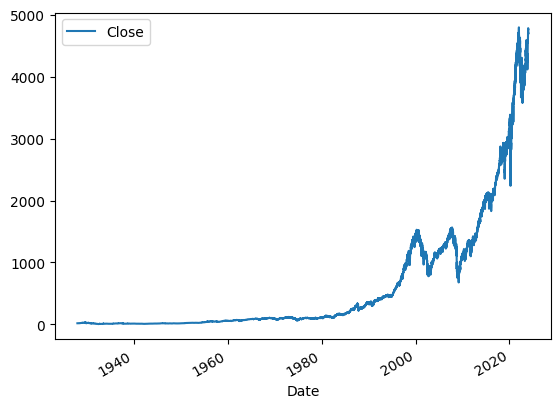

In [7]:
data.plot.line(y="Close", use_index=True)

In [9]:
del data["Dividends"]
del data["Stock Splits"]

In [10]:
data["Tomorrow"] = data["Close"].shift(-1)

In [11]:
data["Target"] = (data["Tomorrow"] > data["Close"]).astype(int)

In [15]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = data.iloc[:-100]
test = data.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [16]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5178571428571429

<Axes: xlabel='Date'>

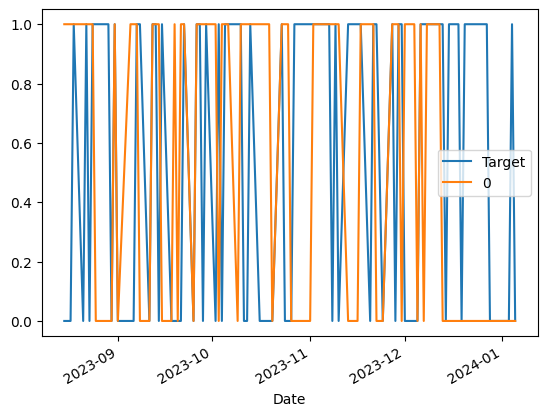

In [17]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [18]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [19]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [29]:
data = data.head(10000)

In [30]:
predictions = backtest(data, model, predictors)

In [31]:
predictions["Predictions"].value_counts()

0    4309
1    3191
Name: Predictions, dtype: int64

In [32]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5133187088686932

In [33]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.524267
0    0.475733
Name: Target, dtype: float64

In [38]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    data[ratio_column] = data["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    data[trend_column] = data.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

<ipython-input-38-cbab26a11d29>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[ratio_column] = data["Close"] / rolling_averages["Close"]
<ipython-input-38-cbab26a11d29>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[trend_column] = data.shift(1).rolling(horizon).sum()["Target"]


In [39]:
data = data.dropna(subset=data.columns[data.columns != "Tomorrow"])

In [40]:
data

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1931-12-29 00:00:00-05:00,7.96,7.960000,7.960000,7.960000,0,8.100000,1,1.012723,1.0,0.996994,3.0,0.821282,24.0,0.582074,105.0,0.394305,521.0
1931-12-30 00:00:00-05:00,8.10,8.100000,8.100000,8.100000,0,8.120000,1,1.008717,2.0,1.019381,3.0,0.837787,25.0,0.593657,105.0,0.401432,521.0
1931-12-31 00:00:00-05:00,8.12,8.120000,8.120000,8.120000,0,7.560000,0,1.001233,2.0,1.017544,4.0,0.842149,25.0,0.596489,105.0,0.402615,522.0
1932-01-04 00:00:00-05:00,7.56,7.560000,7.560000,7.560000,0,7.550000,0,0.964286,1.0,0.956962,3.0,0.785781,25.0,0.556754,104.0,0.375034,522.0
1932-01-05 00:00:00-05:00,7.55,7.550000,7.550000,7.550000,0,8.080000,1,0.999338,0.0,0.960804,3.0,0.787963,24.0,0.557255,104.0,0.374726,521.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967-11-24 00:00:00-05:00,0.00,94.459999,92.739998,93.900002,9470000,94.169998,1,1.001333,2.0,1.009417,4.0,0.991381,34.0,1.035670,139.0,1.088635,546.0
1967-11-27 00:00:00-05:00,0.00,94.800003,93.320000,94.169998,10040000,94.489998,1,1.001436,2.0,1.009390,4.0,0.994039,34.0,1.038018,140.0,1.091510,547.0
1967-11-28 00:00:00-05:00,0.00,95.080002,93.570000,94.489998,11040000,94.470001,0,1.001696,2.0,1.006691,5.0,0.997268,34.0,1.040901,140.0,1.094959,547.0


In [41]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [42]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [44]:
data = data.head(10000)

In [46]:
predictions = backtest(data, model, new_predictors)

In [47]:
predictions["Predictions"].value_counts()

0.0    5703
1.0     797
Name: Predictions, dtype: int64

In [48]:
precision_score(predictions["Target"], predictions["Predictions"])

0.6725219573400251

In [49]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.532462
0    0.467538
Name: Target, dtype: float64

In [50]:
predictions

,Target,Predictions
Date,,
1942-01-07 00:00:00-05:00,0,0.0
1942-01-08 00:00:00-05:00,0,0.0
1942-01-09 00:00:00-05:00,0,0.0
1942-01-12 00:00:00-05:00,1,0.0
1942-01-13 00:00:00-05:00,0,0.0
...,...,...
1967-11-24 00:00:00-05:00,1,0.0
1967-11-27 00:00:00-05:00,1,0.0
1967-11-28 00:00:00-05:00,0,0.0
